## Opis problema

Podsećanja radi, pred nama je skup podataka o pacijentima koji su podvrgnuti **elektrokonverziji** (električnoj kardioverziji). Naš zadatak je da na osnovu dobijenih podataka o pacijentima napravimo **klasifikacioni model** koji tačno predviđa **da li će procedura biti uspešna**.

Ova sveska posvećena je formiranju modela zasnovanih na **Bajesovim mrežama**, poznatom **probabilističkom grafovskom modelu**. Najplastičnije rečeno, Bajesove mreže su zapravo **usmereni graf atributa (faktora)**, kroz koji se **verovanje (*belief*) propagira** kroz svaku granu. Moglo bi se reći da se u svakom čvoru nalazi tabela uslovne raspodele atributa predstavljenog tim čvorom u zavisnosti od svih atributa predstavljenih čvorovima iz kojih polaze grane koje ulaze u taj čvor. Prilikom konkretnog **zaključivanja (*inference*)**, polazi se od čvorova sa poznatim vrednostima atributa, a verovanje se propagira kako unapred, tako i unazad, u skladu sa pravilima zaključivanja. Ovakvi modeli imaju uspeha u primeni nad **kliničkim podacima**, pa ih ima svrhe isprobati.

## Učitavanje podataka

Na početku učitavamo prečišćeni skup iz pripremljene CSV datoteke. Podsećanja radi, podaci su dimenzija **147 × 49**. Redovi predstavljaju pacijente, indeksirane po broju iz baze, dok su atributi redom opisani u svesci posvećenoj pripremi, a predstavljaju kliničke karakteristike pacijenata, terapiju koju uzimaju i neke podatke o samoj elektrokonverziji. Svi ulazni atributi su celobrojnog tipa, dok je poslednji ciljni koji predstavlja uspešnost terapije istininosnog.

In [1]:
import numpy as np
import pandas as pd

dff = pd.read_csv(
        'elektroprecisceno.csv',
         index_col=0
)
dff

,godine,stariji,Pol,indikacija:,ukupno,trajanje,frekvenca,Blok,dimenzija,EDD,...,Sotalol,Digoksin,ASA,OAKT,Plavix,Statin,Implantiran,Vreme,"sinhroni,",Elektrokonverzija
Broj,,,,,,,,,,,,,,,,,,,,,
1,78,1,1,1,5,5,0,3,42,56,...,0,0,0,2,0,0,1,2,2,True
2,61,0,1,2,24,1,7,0,42,59,...,0,0,0,2,0,0,0,-1,2,True
3,65,1,1,1,4,4,0,3,47,55,...,0,0,0,2,0,0,1,3,2,True
4,64,0,1,1,288,2,7,0,50,50,...,0,0,0,2,0,0,0,-1,2,True
5,65,1,2,1,48,3,9,0,49,61,...,0,0,0,2,0,1,0,-1,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,61,0,1,2,2,2,0,3,36,54,...,0,0,0,2,0,0,1,2,2,True
647,58,0,1,2,12,2,0,3,45,57,...,0,0,0,3,0,1,1,2,2,True
648,72,1,2,1,20,20,6,0,43,66,...,0,1,0,3,0,0,0,-1,2,True


## Razvrstavanje atributa

Prvi korak pri radu sa Bajesovim mrežama jeste **diskretizacija** podataka. Iako mreže u suštini mogu raditi i sa neprekidnim podacima, pri čemu se pretpostavlja da oni podležu nekoj poznatoj raspodeli poput normalne, to ovde nije slučaj. Pacijenti podvrgnuti elektrokonverziji sadrže samo celobrojne podatke, i to mnoge indikatorskog tipa, te će zbog toga biti korišćene samo **diskretne Bajesove mreže** – svaki čvor će biti jedan **diskretni faktor**.

Problem nastaje kada atributi imaju veliki broj vrednosti. Tada rezultujuće tabele uslovne raspodele (CPD) postaju ogromne (veličina im je eksponencijalna po kardinalnosti atributa), a takođe dolazi do problema sa previše razbacanim verovatnoćama. Primera radi, godine su atribut visoke kardinalnosti, sa 44 različite vrednosti. Svaka tabela kojoj su pridružene imala bi, dakle, 44 puta više kolona nego CPD bez njih. Osim toga, dobila bi se previše specifična i nepraktična verovanja poput onog da će svakom pacijentu sa tačno 84 godina procedura biti uspešna, a svakom sa tačno 24 biti neuspešna, sve to na osnovu samo po jednog pacijenta tih godina. Dodatno, ne bi bilo moguće izvesti nikakav zaključak npr. za stogodišnjaka, jer takva kategorija ne postoji. Zato se u nastavku vrši dodatno **razvrstavanje (*binning*)** atributa po kategorijama, pri čemu se pazi da korelacija između originalnih i izmenjenih vrednosti ostane dovoljno visoka.

In [2]:
df = dff.copy()
corrs = []

def izmeni(**kwargs):
    [(att, bins)] = kwargs.items()
    df[att] = np.digitize(df[att], bins)
    return np.corrcoef(df[att], dff[att])[0, 1]

corrs.append(izmeni(godine = range(10, 100, 10)))
corrs.append(izmeni(ukupno = [4, 10, 30, 61]))
corrs.append(izmeni(trajanje = [3, 10]))
corrs.append(izmeni(dimenzija = range(30, 56, 5)))
corrs.append(izmeni(EDD = range(40, 66, 5)))
corrs.append(izmeni(ESD = range(20, 66, 5)))
corrs.append(izmeni(EF = range(20, 80, 5)))
corrs.append(izmeni(Vreme = [0, 3, 10]))

corrs

[0.973269468814355,
 0.7288493613422512,
 0.8362367777252501,
 0.9546193076544146,
 0.9293852629054578,
 0.9831993952007181,
 0.9920791972032856,
 0.5697974385743548]

Nove vrednosti atributa sada su kompaktne kategorije pogodne za dalju bajesovsku analizu, što se vidi iz narednog prikaza.

In [3]:
df

,godine,stariji,Pol,indikacija:,ukupno,trajanje,frekvenca,Blok,dimenzija,EDD,...,Sotalol,Digoksin,ASA,OAKT,Plavix,Statin,Implantiran,Vreme,"sinhroni,",Elektrokonverzija
Broj,,,,,,,,,,,,,,,,,,,,,
1,7,1,1,1,1,1,0,3,3,4,...,0,0,0,2,0,0,1,1,2,True
2,6,0,1,2,2,0,7,0,3,4,...,0,0,0,2,0,0,0,0,2,True
3,6,1,1,1,1,1,0,3,4,4,...,0,0,0,2,0,0,1,2,2,True
4,6,0,1,1,4,0,7,0,5,3,...,0,0,0,2,0,0,0,0,2,True
5,6,1,2,1,3,1,9,0,4,5,...,0,0,0,2,0,1,0,0,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,6,0,1,2,0,0,0,3,2,3,...,0,0,0,2,0,0,1,1,2,True
647,5,0,1,2,2,0,0,3,4,4,...,0,0,0,3,0,1,1,1,2,True
648,7,1,2,1,2,2,6,0,3,6,...,0,1,0,3,0,0,0,0,2,True


## Podela na test i trening

Kao i pri svakom problemu klasifikacije, skup podataka deli se na skup za **treniranje** modela i skup za **testiranje** uspeha. Očekivano je da će model biti dobar na skupu na kom je treniran, pa zato postoji drugi validacioni skup za proveru ponašanja na nepoznatim podacima, koje model pre provere nije video. Pri radu sa Bejesovim mrežama, trening skup se koristi kako za učenje strukture mreže, tako i za učenje parametara (tabela). Konkretno je uzet test skup koji pokriva trećinu podataka, a sama podela **stratifikovana** je po ciljnom atributu, jer je on vrlo nebalansiran, pa je taj balans neophodno veštački održati pri podeli. Fiksirano je seme generatora pseudoslučajnih brojeva, kako bi se uvek dobila ista podela, odnosno kako bi test bio **ponovljiv** uvek sa istim rezultatima.

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=0, stratify=df.iloc[:,-1], test_size=0.33)

U potrazi za boljim rezultatima, oprobano je **ponovljeno uzorkovanje** (*resampling*). Naime, Bajesove mreže su osetljive na nebalansiranost, pošto na aposteriornu verovatnoću klase utiče njena apriorna verovatnoća. Konkretno, primenjeno je **prekomerno uzorkovanje** (*oversampling*), i to razne metode iz porodice **tehnika sintetičkog prekomernog uzorkovanja manjine** (SMOTE). Njima je moguće pravljenje veštačkih instanci, odnosno izmišljenih pacijenata kod kojih je elektrokonverzija neuspešna, kako bi takvi redovi bili jednako zastupljeni u skupu za trening. Ovo, međutim, nimalo nije poboljšalo rezultate.

## Pomoćne funkcije

Napisane su tri pomoćne funkcije za rad sa Bajesovim mrežama. Prva na osnovu modela, trening i test skupa (skupovi mogu biti isti) trenira prosleđeni model i dohvata predviđene (stepen poverenja u vidu realnog broja od 0 do 1) i prave oznake klase (ceo broj 0 ili 1). Druga ocenjuje uspeh modela pomoću matrice konfuzije i izveštaja o klasifikaciji. Kako Bajesove mreže predviđaju **izglede uspeha**, ova funkcija kao argument prima i **granicu (*threshold*) poverenja**, koja je podrazumevano 50 %. Treća ilustruje rezultate tako što na *x*-osi predstavlja stepen i granicu poverenja, dok je na *y*-osi tačna oznaka klase. U istoj ćeliji implementirana je i lažna (*dummy*) klasa *MojKlasifikator*, koja pomaže u crtanju **toplotne mape matrice konfuzije**, umesto obične matrice.

In [5]:
import bnlearn as bn
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, classification_report

y_pred = []
gran = [0.5]

class MojKlasifikator:
    _estimator_type = 'classifier'
    
    def predict(*args):
        return [y > gran[0] for y in y_pred]

def dohvati(model, tren, test):
    if 'config' in model:
        print(model['config'])
        print()
    
    if tren is not None:
        model = bn.parameter_learning.fit(model, tren, verbose=0)
    
    ciljna = test.columns[-1]
    y_true = []
    
    global y_pred
    y_pred.clear()
    
    for _, row in test.iterrows():
        ev = {att: row[att] for att in model['adjmat'] if att in row[:-1]}
        p = bn.inference.fit(model, variables=[ciljna], evidence=ev, verbose=0)
        
        y_true.append(row[ciljna])
        y_pred.append(p.get_value(**{ciljna: True})[0][-1])
    return y_pred, y_true

def oceni(y_pred, y_true, thresh=0.5, klasif=MojKlasifikator, test=[]):
    global gran
    gran[0] = thresh
    
    y_pred = [y > thresh for y in y_pred]
    
    print(classification_report(y_true, y_pred))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4),
                                   gridspec_kw={'width_ratios': [4, 5]})
    fig.subplots_adjust(right=1.2)
    
    plot_confusion_matrix(klasif, test, y_true,
                          colorbar=False, cmap='Reds', ax=ax1)
    ax1.set_xlabel('Predviđeno')
    ax1.set_ylabel('Stvarno')
    ax1.set_title('Matrica konfuzije')
    
    return ax2

def nacrtaj(x, y, ax, naslov, thresh=0.5):
    x, y = np.array(x), np.array(y)
    ax.scatter(x[y], y[y])
    ax.scatter(x[~y], y[~y])
    
    ax.set_title(naslov)
    
    ax.vlines(thresh, -0.05, 1.05, 'red')
    
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    
    ax.set_xlabel('Predviđeno')
    ax.set_ylabel('Stvarno')
    
    plt.show()

## Učenje strukture

Prvi oprobani metod izgradnje modela Bajesove mreže jeste **učenje strukture**. Postoji nekoliko heurističkih algoritma za izgradnju najbolje strukture mreže, zapravo rasporeda grana. Svi su oprobani, a najbolje se pokazao podrazumevani model, bez nekog posebnog podešavanja hiperparametara.

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Plot based on BayesianModel


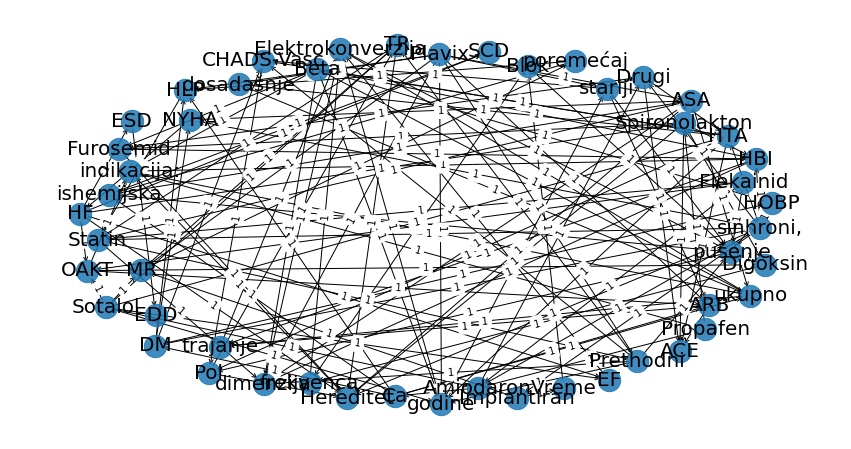

In [6]:
#from itertools import product

models = [bn.structure_learning.fit(df_train),]
#          bn.structure_learning.fit(df_train, 'cs', verbose=0),
#          *(bn.structure_learning.fit(df, m, s) for m, s in prod(('hc', 'ex'), ('bic', 'k2', 'bdeu'))),
#          *(bn.structure_learning.fit(df_train, 'cl', root_node=att, verbose=0) for att in df.columns)]

_ = bn.plot(models[0])

Ovakav model dobro se pokazuje na skupu za trening. Sveukupna tačnost je odličnih $95 \%$, odziv je $98 \%$, a specifičnost $73 \%$. I ostale mere su odlične.

{'verbose': 3, 'method': 'hc', 'scoring': 'bic', 'black_list': None, 'white_list': None, 'bw_list_method': None, 'max_indegree': None, 'tabu_length': 100, 'epsilon': 0.0001, 'max_iter': 1000000.0, 'root_node': None}

              precision    recall  f1-score   support

       False       0.80      0.73      0.76        11
        True       0.97      0.98      0.97        87

    accuracy                           0.95        98
   macro avg       0.88      0.85      0.87        98
weighted avg       0.95      0.95      0.95        98



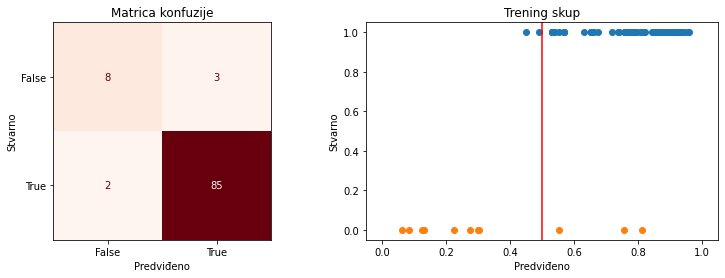

In [7]:
for model in models:
    trenx, treny = dohvati(model, df_train, df_train)
    ax = oceni(trenx, treny)
    nacrtaj(trenx, treny, ax, 'Trening skup')

Ipak, model nije dobar na bitnijem test skupu. Primera radi, specifičnost je svega $17 \%$, vrlo loša, pa je model sveukupno **preprilagođen**.

{'verbose': 3, 'method': 'hc', 'scoring': 'bic', 'black_list': None, 'white_list': None, 'bw_list_method': None, 'max_indegree': None, 'tabu_length': 100, 'epsilon': 0.0001, 'max_iter': 1000000.0, 'root_node': None}

              precision    recall  f1-score   support

       False       0.20      0.17      0.18         6
        True       0.89      0.91      0.90        43

    accuracy                           0.82        49
   macro avg       0.54      0.54      0.54        49
weighted avg       0.80      0.82      0.81        49



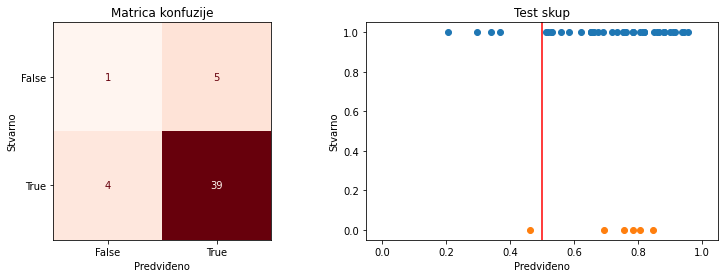

In [8]:
for model in models:
    testx, testy = dohvati(model, df_train, df_test)
    ax = oceni(testx, testy)
    nacrtaj(testx, testy, ax, 'Test skup')

## Naivni Bajes

Sledeći oprobani model je **naivni Bajes**. U pitanju je model koji se oslanja na specifičnu strukturu mreže, takvu da su joj grane usmerene iključivo od ciljnog atributa ka ulaznim, pri čemu sve takve grane postoje, i nijedna druga. Naivan je zato što su kod njega ulazni atributi međusobno nezavisni pri ciljnom.

[bnlearn] >No changes made to existing Bayesian DAG.
[bnlearn] >Plot based on BayesianModel


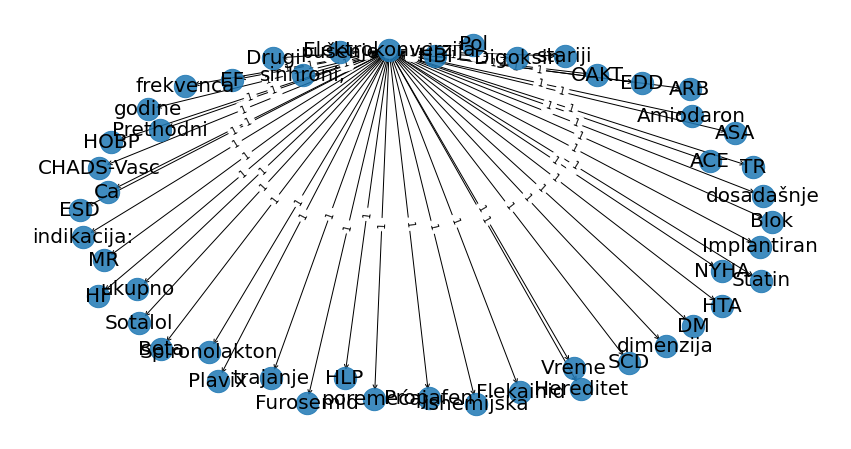

In [9]:
from pgmpy.models import NaiveBayes

nb = NaiveBayes()
nb.fit(df_train, 'Elektrokonverzija')
nb = bn.make_DAG(nb)

_ = bn.plot(nb)

Nažalost, ovakav model je **apsolutno potprilagođen**. Sve procedure predviđa kao uspešne, poput naivnog modela iz uvodnih razmatranja.

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        11
        True       0.89      1.00      0.94        87

    accuracy                           0.89        98
   macro avg       0.44      0.50      0.47        98
weighted avg       0.79      0.89      0.83        98



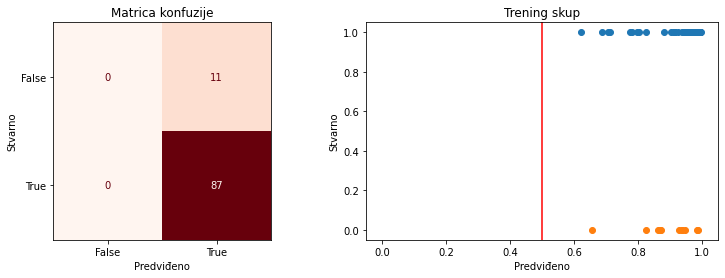

In [10]:
trenx, treny = dohvati(nb, df_train, df_train)
ax = oceni(trenx, treny)
nacrtaj(trenx, treny, ax, 'Trening skup')

Očekivano, isto ponašanje je i na test skupu, s tim što je ovde model još uvereniji da je baš svaka elektrokonverzija uspešna, što se može primetiti sa slike.

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         6
        True       0.88      1.00      0.93        43

    accuracy                           0.88        49
   macro avg       0.44      0.50      0.47        49
weighted avg       0.77      0.88      0.82        49



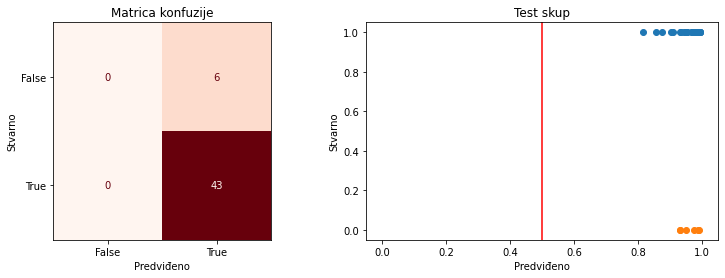

In [11]:
testx, testy = dohvati(nb, df_train, df_test)
ax = oceni(testx, testy)
nacrtaj(testx, testy, ax, 'Test skup')

## Ručni naivni

Naivni Bajes može se lako implementirati i bez uvođenja pojma Bajesove mreže i grafa. Takva implementacija je čak i efikasnija, a pritom se može podesiti davanje veće verovatnoće retkim klasama, kako bi se popravile česte greške naivnih pretpostavki. **Ručno implementirana verzija** data je u nastavku.

In [12]:
from functools import reduce
from operator import mul

prod = lambda niz: reduce(mul, niz, 1)
norm = lambda dic: (np.array([*dic.values()]) / np.sum(np.array([*dic.values()])))[1]

class MojNaivniBajes:
    _estimator_type = 'classifier'
    
    def fit(self, df_train):
        self.ulazni = df_train.columns[:-1]
        self.ciljni = df_train.columns[-1]
        
        self.klase = sorted(list(set(df_train[self.ciljni])))
        
        self.probs = {klasa: {atribut: 16*[0.00005] for atribut in self.ulazni} for klasa in self.klase}
        
        self.vrvk = {klasa: len(df_train[df_train[self.ciljni] == klasa]) / len(df_train) for klasa in self.klase}
        
        for indeks in df_train.index:
            klasa = df_train.loc[indeks, self.ciljni]
            for atribut in self.ulazni:
                self.probs[klasa][atribut][df_train.loc[indeks, atribut]] += 1/self.vrvk[klasa]
    
    def predictt(self, df_test):
        y_pred = []
        
        for indeks in df_test.index:
            odabir = {klasa: prod([self.probs[klasa][atribut][df_test.loc[indeks, atribut]]
                                   for atribut in self.ulazni]) for klasa in self.klase}
            y_pred.append(norm(odabir))
        
        return y_pred
    
    def predict(self, df_test, thresh=0.5):
        return [y > thresh for y in self.predictt(df_test)]
    
    def score(self, df_test, naslov):
        y_true = df_test.loc[:, self.ciljni]
        y_pred = self.predictt(df_test)
        
        ax = oceni(y_pred, y_true, klasif=self, test=df_test)
        nacrtaj(y_pred, y_true, ax, naslov)

mnb = MojNaivniBajes()
mnb.fit(df_train)

Uspeh na trening skupu je dosad najbolji, sa tačnošću $95 \%$, odzivom $95 \%$ i specifičnošću $91 \%$. I ostale mere su odlične.

              precision    recall  f1-score   support

       False       0.71      0.91      0.80        11
        True       0.99      0.95      0.97        87

    accuracy                           0.95        98
   macro avg       0.85      0.93      0.89        98
weighted avg       0.96      0.95      0.95        98



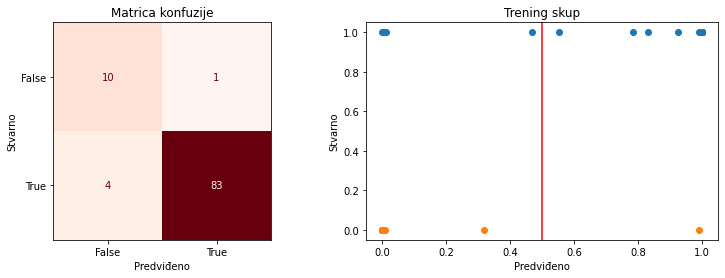

In [13]:
mnb.score(df_train, 'Trening skup')

Ipak, na test skupu se dobijaju rezultati ravni naivnom klasifikatoru, čak malo gori zbog jedne lažno neuspešne terapije, pa je i ovaj model **preprilagođen**.

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         6
        True       0.88      0.98      0.92        43

    accuracy                           0.86        49
   macro avg       0.44      0.49      0.46        49
weighted avg       0.77      0.86      0.81        49



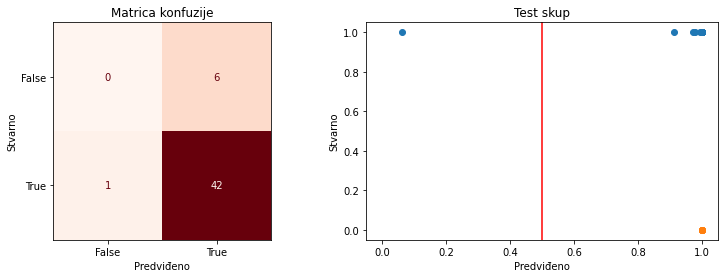

In [14]:
mnb.score(df_test, 'Test skup')

## Forsiranje grana

Poslednja oprobana strategija je **forsiranje grana**. To je učenje strukture, pri kom već postoje određene grane, a koje se tokom optimizacionog algoritma ne smeju izbaciti. Uzete su četiri grane koje se završavaju u ciljnom atributu, a polaze iz **važnih prediktora** prema ranije razmatranom drvetu odlučivanja. Takav raspored znači da će vrednosti tih atributa imati najveći značaj pri zaključivanju vrednosti ciljnog – stepena poverenja u uspeh elektrokonverzije.

  0%|          | 129/1000000 [02:07<274:48:42,  1.01it/s] 


[bnlearn] >No changes made to existing Bayesian DAG.
[bnlearn] >Plot based on BayesianModel


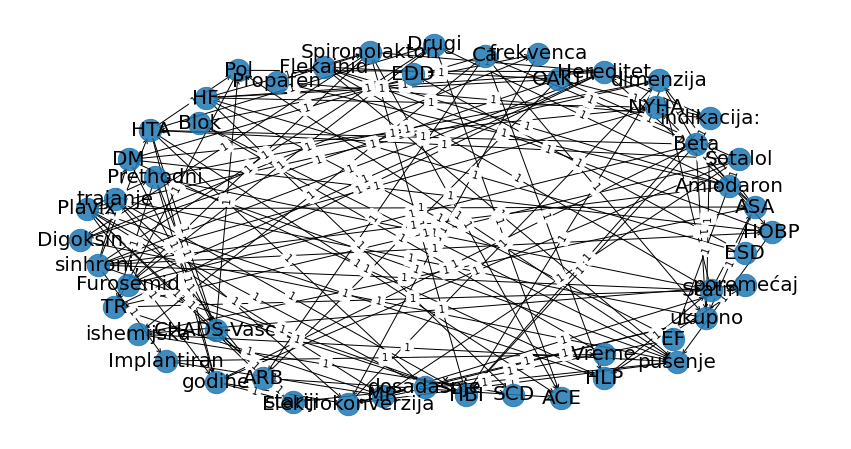

In [15]:
from pgmpy.estimators import HillClimbSearch

est = HillClimbSearch(df_train)
fixed = est.estimate(fixed_edges=[('godine', 'Elektrokonverzija'),
                                  ('ukupno', 'Elektrokonverzija'),
                                  ('frekvenca', 'Elektrokonverzija'),
                                  ('EF', 'Elektrokonverzija')])
fixed = bn.make_DAG(fixed)

_ = bn.plot(fixed)

Metrike ovog modela na trening skupu su **savršene**. Svaka instanca je ispravno klasifikovana, i to sa **vrlo visokim stepenom poverenja**.

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        11
        True       1.00      1.00      1.00        87

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



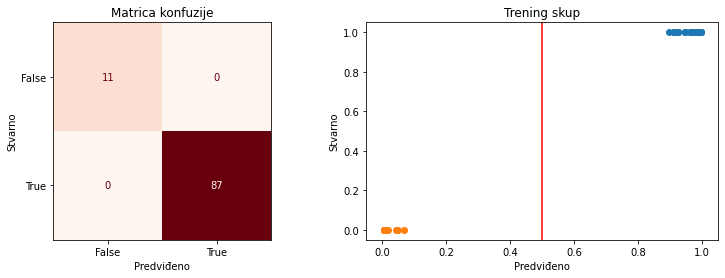

In [16]:
trenx, treny = dohvati(fixed, df_train, df_train)
ax = oceni(trenx, treny)
nacrtaj(trenx, treny, ax, 'Trening skup')

Nažalost, uspeh na test skupu je lošiji. Tačnost je tek $59 \%$, odziv $63 \%$, a specifičnost $33 \%$. Model je, dakle, **apsolutno preprilagođen**.

              precision    recall  f1-score   support

       False       0.11      0.33      0.17         6
        True       0.87      0.63      0.73        43

    accuracy                           0.59        49
   macro avg       0.49      0.48      0.45        49
weighted avg       0.78      0.59      0.66        49



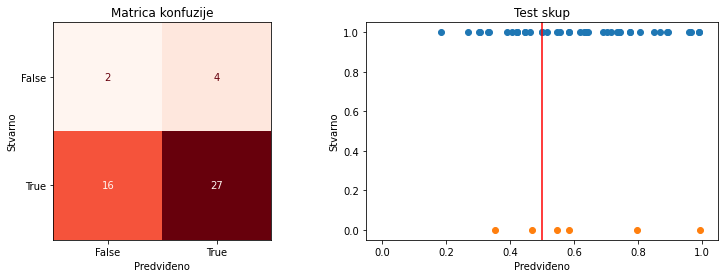

In [17]:
testx, testy = dohvati(fixed, df_train, df_test)
ax = oceni(testx, testy)
nacrtaj(testx, testy, ax, 'Test skup')

Oprobano je i nekoliko drugih kombinacija na osnovu odsecanja razmotrenog **dendrograma atributa**, sa sledećom kao najuspešnijom.

  0%|          | 128/1000000 [01:50<238:53:21,  1.16it/s]


[bnlearn] >No changes made to existing Bayesian DAG.
[bnlearn] >Plot based on BayesianModel


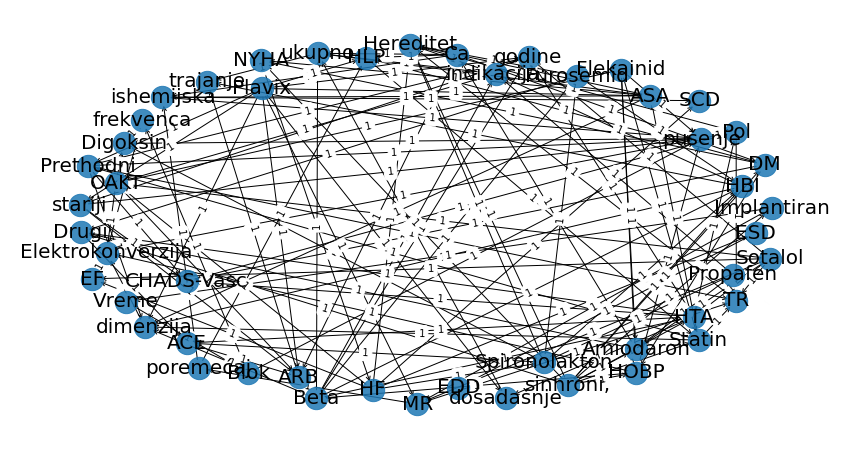

In [18]:
fixed = est.estimate(fixed_edges=[('dimenzija', 'Elektrokonverzija'),
                                  ('OAKT', 'Elektrokonverzija'),
                                  ('frekvenca', 'Elektrokonverzija'),
                                  ('EF', 'Elektrokonverzija')])
fixed = bn.make_DAG(fixed)

_ = bn.plot(fixed)

I ovde je, naravno, model skoro u potpunosti ukalupljen u skup za treniranje, mada sa nižim stepenima poverenja.

              precision    recall  f1-score   support

       False       1.00      0.91      0.95        11
        True       0.99      1.00      0.99        87

    accuracy                           0.99        98
   macro avg       0.99      0.95      0.97        98
weighted avg       0.99      0.99      0.99        98



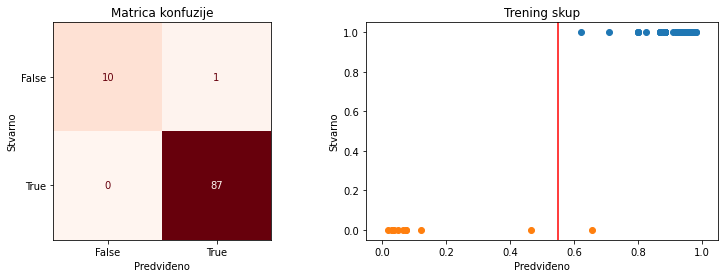

In [19]:
trenx, treny = dohvati(fixed, df_train, df_train)
ax = oceni(trenx, treny, 0.55)
nacrtaj(trenx, treny, ax, 'Trening skup', 0.55)

Međutim, na test skupu je ponašanje znatno bolje. Odziv, specifičnost i sveukupna tačnost su oko dve trećine.

              precision    recall  f1-score   support

       False       0.20      0.67      0.31         6
        True       0.93      0.63      0.75        43

    accuracy                           0.63        49
   macro avg       0.57      0.65      0.53        49
weighted avg       0.84      0.63      0.70        49



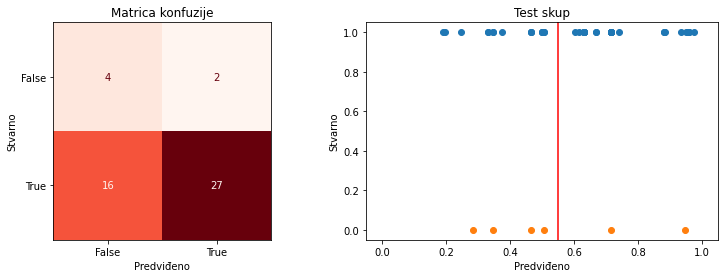

In [20]:
testx, testy = dohvati(fixed, df_train, df_test)
ax = oceni(testx, testy, 0.55)
nacrtaj(testx, testy, ax, 'Test skup', 0.55)